# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

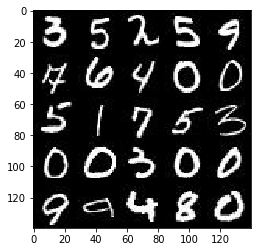

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

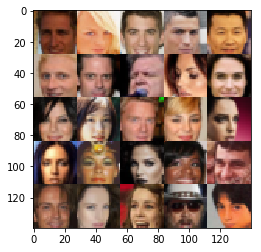

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeba_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeba_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="real_input")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, lrelu_alpha=0.2):
        return tf.maximum(lrelu_alpha * x, x)

def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input is N*28*28*3
        # output = N*14*14*64
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                                 kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01))
        layer1 = leaky_relu(layer1, alpha)
        
        # output = N*7*7*128
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same',
                                 kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01))
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = leaky_relu(layer2, alpha)
        
        # output = N*4*4*256
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same',
                                 kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01))
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = leaky_relu(layer3, alpha)
                
        flat = tf.layers.flatten(layer3)
        logits = tf.layers.dense(flat, 1,
                                )
        out = tf.sigmoid(logits)      

    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, reuse=None):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    local_reuse = (not is_train) if not reuse else reuse
    
    with tf.variable_scope("generator", reuse=local_reuse):
        
        # input: N*z_dim
        # output: 7*7*256
        layer1 = tf.layers.dense(z, 7*7*256, 
                                 kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01))
        layer1 = tf.reshape(layer1, (-1, 7, 7, 256))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(layer1, alpha)
        
        # output: N*14*14*128
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, strides=2, padding='same',
                                           kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01))
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = leaky_relu(layer2, alpha)
        
        # output: N*28*28*64
        layer3 = tf.layers.conv2d_transpose(layer2, 64, 5, strides=2, padding='same',
                                           kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01))
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = leaky_relu(layer3, alpha)     
        
        # output: N*28*28*3
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01))
        
        out = tf.tanh(logits)        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, real_label_smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - real_label_smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    ctrl = [op for op in ops if op.name.startswith('generator')]

    with tf.control_dependencies(ctrl):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):

        self.input_real, self.input_z, learn_rate = model_inputs(*real_size,  z_size)
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)    
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1,
          get_batches, data_shape, data_image_mode, print_every=1, show_every=5):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    steps = 0
    e = 0
    samples, losses = [], []
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            e += 1
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images
                                                   })
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})
                    print("Epoch {}/{}...".format(e, epoch_count),
                          "Iteration {}".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))   
                    
                    if steps % show_every == 0:
                        out_channel_dim = net.input_real.shape[-1]
                        image_mode = 'L' if out_channel_dim == 1 else 'RGB'
                        gen_samples = sess.run(
                                       generator(net.input_z, out_channel_dim, reuse=True, is_train=False),
                                       feed_dict={net.input_z: batch_z})
                        samples.append(gen_samples)
                        show_generator_output(sess, 36, net.input_z, out_channel_dim, image_mode)
              

In [13]:
device = tf.device('/gpu:0')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Iteration 10 Discriminator Loss: 1.0510... Generator Loss: 0.7587
Epoch 1/2... Iteration 20 Discriminator Loss: 1.6375... Generator Loss: 0.3792
Epoch 1/2... Iteration 30 Discriminator Loss: 0.6816... Generator Loss: 1.6369
Epoch 1/2... Iteration 40 Discriminator Loss: 0.8444... Generator Loss: 1.0773
Epoch 1/2... Iteration 50 Discriminator Loss: 1.4110... Generator Loss: 0.4613
Epoch 1/2... Iteration 60 Discriminator Loss: 1.3818... Generator Loss: 0.6178
Epoch 1/2... Iteration 70 Discriminator Loss: 1.0250... Generator Loss: 1.0879
Epoch 1/2... Iteration 80 Discriminator Loss: 1.1682... Generator Loss: 0.6975
Epoch 1/2... Iteration 90 Discriminator Loss: 1.0945... Generator Loss: 0.7450
Epoch 1/2... Iteration 100 Discriminator Loss: 1.1611... Generator Loss: 0.7034


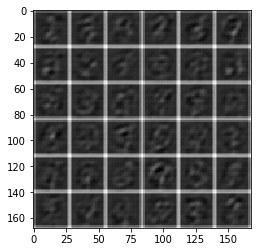

Epoch 1/2... Iteration 110 Discriminator Loss: 1.1460... Generator Loss: 0.7253
Epoch 1/2... Iteration 120 Discriminator Loss: 1.0799... Generator Loss: 0.8729
Epoch 1/2... Iteration 130 Discriminator Loss: 1.5040... Generator Loss: 0.8674
Epoch 1/2... Iteration 140 Discriminator Loss: 1.1019... Generator Loss: 0.7554
Epoch 1/2... Iteration 150 Discriminator Loss: 1.1786... Generator Loss: 1.1353
Epoch 1/2... Iteration 160 Discriminator Loss: 1.4516... Generator Loss: 1.6519
Epoch 1/2... Iteration 170 Discriminator Loss: 0.7841... Generator Loss: 1.2970
Epoch 1/2... Iteration 180 Discriminator Loss: 0.7993... Generator Loss: 1.8581
Epoch 1/2... Iteration 190 Discriminator Loss: 0.8738... Generator Loss: 1.3661
Epoch 1/2... Iteration 200 Discriminator Loss: 0.9145... Generator Loss: 1.8525


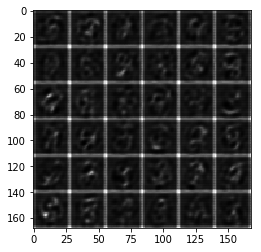

Epoch 1/2... Iteration 210 Discriminator Loss: 0.9349... Generator Loss: 1.4434
Epoch 1/2... Iteration 220 Discriminator Loss: 0.8592... Generator Loss: 1.1971
Epoch 1/2... Iteration 230 Discriminator Loss: 1.2943... Generator Loss: 0.6054
Epoch 1/2... Iteration 240 Discriminator Loss: 0.9864... Generator Loss: 1.2492
Epoch 1/2... Iteration 250 Discriminator Loss: 1.1532... Generator Loss: 0.7492
Epoch 1/2... Iteration 260 Discriminator Loss: 1.1152... Generator Loss: 3.3575
Epoch 1/2... Iteration 270 Discriminator Loss: 0.8419... Generator Loss: 1.4616
Epoch 1/2... Iteration 280 Discriminator Loss: 0.7480... Generator Loss: 1.7088
Epoch 1/2... Iteration 290 Discriminator Loss: 0.8667... Generator Loss: 1.5992
Epoch 1/2... Iteration 300 Discriminator Loss: 1.1985... Generator Loss: 0.6561


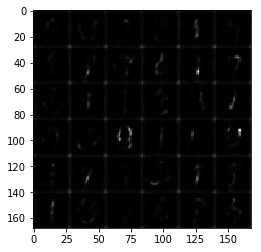

Epoch 1/2... Iteration 310 Discriminator Loss: 1.3256... Generator Loss: 0.6074
Epoch 1/2... Iteration 320 Discriminator Loss: 1.1010... Generator Loss: 2.3431
Epoch 1/2... Iteration 330 Discriminator Loss: 1.0693... Generator Loss: 0.9722
Epoch 1/2... Iteration 340 Discriminator Loss: 1.0298... Generator Loss: 1.1330
Epoch 1/2... Iteration 350 Discriminator Loss: 0.9940... Generator Loss: 1.8246
Epoch 1/2... Iteration 360 Discriminator Loss: 1.2139... Generator Loss: 0.7279
Epoch 1/2... Iteration 370 Discriminator Loss: 1.6451... Generator Loss: 0.3869
Epoch 1/2... Iteration 380 Discriminator Loss: 0.9915... Generator Loss: 1.0625
Epoch 1/2... Iteration 390 Discriminator Loss: 1.0695... Generator Loss: 1.7376
Epoch 1/2... Iteration 400 Discriminator Loss: 1.1323... Generator Loss: 1.3729


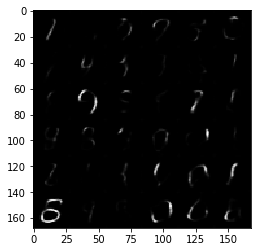

Epoch 1/2... Iteration 410 Discriminator Loss: 1.0115... Generator Loss: 1.3278
Epoch 1/2... Iteration 420 Discriminator Loss: 0.9184... Generator Loss: 1.7130
Epoch 1/2... Iteration 430 Discriminator Loss: 1.0864... Generator Loss: 1.0222
Epoch 1/2... Iteration 440 Discriminator Loss: 1.2697... Generator Loss: 0.8079
Epoch 1/2... Iteration 450 Discriminator Loss: 0.9999... Generator Loss: 1.0276
Epoch 1/2... Iteration 460 Discriminator Loss: 1.1389... Generator Loss: 0.8576
Epoch 1/2... Iteration 470 Discriminator Loss: 1.0569... Generator Loss: 0.8979
Epoch 1/2... Iteration 480 Discriminator Loss: 1.3945... Generator Loss: 0.5823
Epoch 1/2... Iteration 490 Discriminator Loss: 1.2094... Generator Loss: 0.8020
Epoch 1/2... Iteration 500 Discriminator Loss: 1.0103... Generator Loss: 1.0328


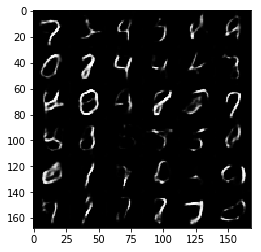

Epoch 1/2... Iteration 510 Discriminator Loss: 1.2161... Generator Loss: 0.7258
Epoch 1/2... Iteration 520 Discriminator Loss: 1.0585... Generator Loss: 1.1590
Epoch 1/2... Iteration 530 Discriminator Loss: 1.3852... Generator Loss: 0.5460
Epoch 1/2... Iteration 540 Discriminator Loss: 1.1288... Generator Loss: 1.0234
Epoch 1/2... Iteration 550 Discriminator Loss: 1.3268... Generator Loss: 0.5936
Epoch 1/2... Iteration 560 Discriminator Loss: 1.1278... Generator Loss: 1.5024
Epoch 1/2... Iteration 570 Discriminator Loss: 1.0509... Generator Loss: 0.9150
Epoch 1/2... Iteration 580 Discriminator Loss: 1.0821... Generator Loss: 0.9767
Epoch 1/2... Iteration 590 Discriminator Loss: 1.1075... Generator Loss: 0.8236
Epoch 1/2... Iteration 600 Discriminator Loss: 1.0558... Generator Loss: 1.0560


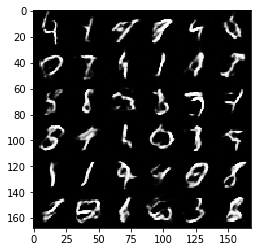

Epoch 1/2... Iteration 610 Discriminator Loss: 0.9816... Generator Loss: 1.0055
Epoch 1/2... Iteration 620 Discriminator Loss: 1.1478... Generator Loss: 1.0643
Epoch 1/2... Iteration 630 Discriminator Loss: 1.0377... Generator Loss: 1.0979
Epoch 1/2... Iteration 640 Discriminator Loss: 1.3149... Generator Loss: 0.6424
Epoch 1/2... Iteration 650 Discriminator Loss: 1.0449... Generator Loss: 2.0678
Epoch 1/2... Iteration 660 Discriminator Loss: 0.9448... Generator Loss: 1.1213
Epoch 1/2... Iteration 670 Discriminator Loss: 0.9671... Generator Loss: 1.1313
Epoch 1/2... Iteration 680 Discriminator Loss: 1.0294... Generator Loss: 1.0371
Epoch 1/2... Iteration 690 Discriminator Loss: 1.0253... Generator Loss: 0.9784
Epoch 1/2... Iteration 700 Discriminator Loss: 0.8686... Generator Loss: 1.3263


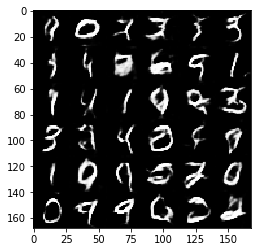

Epoch 1/2... Iteration 710 Discriminator Loss: 1.1876... Generator Loss: 0.7004
Epoch 1/2... Iteration 720 Discriminator Loss: 1.0606... Generator Loss: 0.9551
Epoch 1/2... Iteration 730 Discriminator Loss: 1.0616... Generator Loss: 0.9079
Epoch 1/2... Iteration 740 Discriminator Loss: 0.9753... Generator Loss: 1.0481
Epoch 1/2... Iteration 750 Discriminator Loss: 0.9558... Generator Loss: 1.1678
Epoch 1/2... Iteration 760 Discriminator Loss: 1.0140... Generator Loss: 0.8858
Epoch 1/2... Iteration 770 Discriminator Loss: 0.9665... Generator Loss: 0.9803
Epoch 1/2... Iteration 780 Discriminator Loss: 0.9490... Generator Loss: 1.3903
Epoch 1/2... Iteration 790 Discriminator Loss: 1.0835... Generator Loss: 0.8471
Epoch 1/2... Iteration 800 Discriminator Loss: 0.9302... Generator Loss: 1.5811


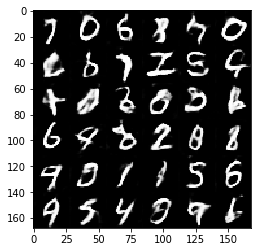

Epoch 1/2... Iteration 810 Discriminator Loss: 1.3128... Generator Loss: 0.5824
Epoch 1/2... Iteration 820 Discriminator Loss: 1.2002... Generator Loss: 2.0842
Epoch 1/2... Iteration 830 Discriminator Loss: 1.0503... Generator Loss: 1.0375
Epoch 1/2... Iteration 840 Discriminator Loss: 1.1358... Generator Loss: 0.7306
Epoch 1/2... Iteration 850 Discriminator Loss: 1.0236... Generator Loss: 0.8643
Epoch 1/2... Iteration 860 Discriminator Loss: 1.0148... Generator Loss: 0.9476
Epoch 1/2... Iteration 870 Discriminator Loss: 0.9812... Generator Loss: 1.2315
Epoch 1/2... Iteration 880 Discriminator Loss: 1.1299... Generator Loss: 0.8301
Epoch 1/2... Iteration 890 Discriminator Loss: 1.3435... Generator Loss: 0.5624
Epoch 1/2... Iteration 900 Discriminator Loss: 1.0703... Generator Loss: 1.0294


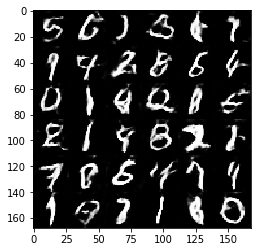

Epoch 1/2... Iteration 910 Discriminator Loss: 1.3133... Generator Loss: 0.6381
Epoch 1/2... Iteration 920 Discriminator Loss: 1.3281... Generator Loss: 0.5871
Epoch 1/2... Iteration 930 Discriminator Loss: 0.9275... Generator Loss: 1.3111
Epoch 2/2... Iteration 940 Discriminator Loss: 0.9834... Generator Loss: 1.5036
Epoch 2/2... Iteration 950 Discriminator Loss: 1.0946... Generator Loss: 1.7200
Epoch 2/2... Iteration 960 Discriminator Loss: 1.3453... Generator Loss: 0.6207
Epoch 2/2... Iteration 970 Discriminator Loss: 1.1316... Generator Loss: 0.8260
Epoch 2/2... Iteration 980 Discriminator Loss: 1.2346... Generator Loss: 0.6210
Epoch 2/2... Iteration 990 Discriminator Loss: 1.0418... Generator Loss: 1.4795
Epoch 2/2... Iteration 1000 Discriminator Loss: 1.1143... Generator Loss: 0.8109


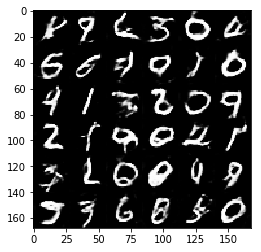

Epoch 2/2... Iteration 1010 Discriminator Loss: 1.0006... Generator Loss: 1.1786
Epoch 2/2... Iteration 1020 Discriminator Loss: 0.8476... Generator Loss: 1.8571
Epoch 2/2... Iteration 1030 Discriminator Loss: 1.2673... Generator Loss: 0.6107
Epoch 2/2... Iteration 1040 Discriminator Loss: 0.8426... Generator Loss: 1.2280
Epoch 2/2... Iteration 1050 Discriminator Loss: 1.4326... Generator Loss: 0.5029
Epoch 2/2... Iteration 1060 Discriminator Loss: 1.4186... Generator Loss: 0.5924
Epoch 2/2... Iteration 1070 Discriminator Loss: 0.9555... Generator Loss: 1.0064
Epoch 2/2... Iteration 1080 Discriminator Loss: 1.2051... Generator Loss: 0.6637
Epoch 2/2... Iteration 1090 Discriminator Loss: 1.0063... Generator Loss: 1.0181
Epoch 2/2... Iteration 1100 Discriminator Loss: 0.9540... Generator Loss: 1.3697


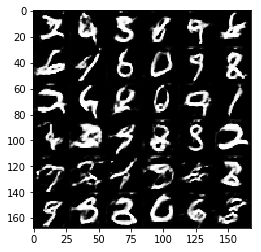

Epoch 2/2... Iteration 1110 Discriminator Loss: 0.9545... Generator Loss: 1.6214
Epoch 2/2... Iteration 1120 Discriminator Loss: 1.1621... Generator Loss: 0.8770
Epoch 2/2... Iteration 1130 Discriminator Loss: 1.0528... Generator Loss: 0.9884
Epoch 2/2... Iteration 1140 Discriminator Loss: 1.2756... Generator Loss: 0.5951
Epoch 2/2... Iteration 1150 Discriminator Loss: 0.9294... Generator Loss: 1.1104
Epoch 2/2... Iteration 1160 Discriminator Loss: 1.1700... Generator Loss: 0.7245
Epoch 2/2... Iteration 1170 Discriminator Loss: 1.0738... Generator Loss: 0.8681
Epoch 2/2... Iteration 1180 Discriminator Loss: 1.4939... Generator Loss: 0.4748
Epoch 2/2... Iteration 1190 Discriminator Loss: 1.2493... Generator Loss: 0.6159
Epoch 2/2... Iteration 1200 Discriminator Loss: 1.1673... Generator Loss: 0.7152


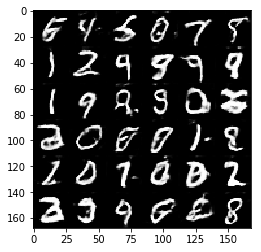

Epoch 2/2... Iteration 1210 Discriminator Loss: 1.0473... Generator Loss: 0.8221
Epoch 2/2... Iteration 1220 Discriminator Loss: 0.9434... Generator Loss: 1.4344
Epoch 2/2... Iteration 1230 Discriminator Loss: 0.9304... Generator Loss: 1.5681
Epoch 2/2... Iteration 1240 Discriminator Loss: 0.9349... Generator Loss: 1.3612
Epoch 2/2... Iteration 1250 Discriminator Loss: 1.4631... Generator Loss: 0.5808
Epoch 2/2... Iteration 1260 Discriminator Loss: 0.9951... Generator Loss: 0.9280
Epoch 2/2... Iteration 1270 Discriminator Loss: 0.8760... Generator Loss: 1.2224
Epoch 2/2... Iteration 1280 Discriminator Loss: 1.1707... Generator Loss: 0.7274
Epoch 2/2... Iteration 1290 Discriminator Loss: 1.1403... Generator Loss: 0.7359
Epoch 2/2... Iteration 1300 Discriminator Loss: 1.3900... Generator Loss: 0.5227


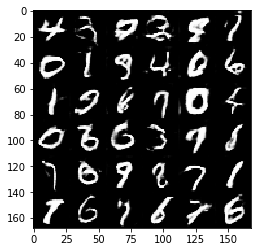

Epoch 2/2... Iteration 1310 Discriminator Loss: 1.0887... Generator Loss: 2.0551
Epoch 2/2... Iteration 1320 Discriminator Loss: 0.9274... Generator Loss: 1.0755
Epoch 2/2... Iteration 1330 Discriminator Loss: 0.9512... Generator Loss: 1.0302
Epoch 2/2... Iteration 1340 Discriminator Loss: 1.1446... Generator Loss: 0.8222
Epoch 2/2... Iteration 1350 Discriminator Loss: 1.7617... Generator Loss: 0.3952
Epoch 2/2... Iteration 1360 Discriminator Loss: 1.1775... Generator Loss: 1.1807
Epoch 2/2... Iteration 1370 Discriminator Loss: 1.0081... Generator Loss: 0.9659
Epoch 2/2... Iteration 1380 Discriminator Loss: 1.1357... Generator Loss: 0.9970
Epoch 2/2... Iteration 1390 Discriminator Loss: 0.8847... Generator Loss: 1.3130
Epoch 2/2... Iteration 1400 Discriminator Loss: 0.8316... Generator Loss: 1.3787


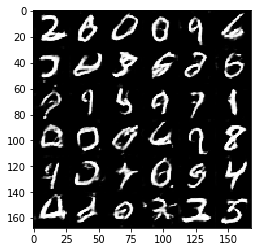

Epoch 2/2... Iteration 1410 Discriminator Loss: 0.9815... Generator Loss: 1.1511
Epoch 2/2... Iteration 1420 Discriminator Loss: 1.0907... Generator Loss: 0.8031
Epoch 2/2... Iteration 1430 Discriminator Loss: 1.2265... Generator Loss: 2.6830
Epoch 2/2... Iteration 1440 Discriminator Loss: 1.0723... Generator Loss: 0.8013
Epoch 2/2... Iteration 1450 Discriminator Loss: 0.8261... Generator Loss: 1.2966
Epoch 2/2... Iteration 1460 Discriminator Loss: 1.1814... Generator Loss: 0.7021
Epoch 2/2... Iteration 1470 Discriminator Loss: 0.9280... Generator Loss: 1.0746
Epoch 2/2... Iteration 1480 Discriminator Loss: 0.9298... Generator Loss: 1.0831
Epoch 2/2... Iteration 1490 Discriminator Loss: 0.9579... Generator Loss: 2.1048
Epoch 2/2... Iteration 1500 Discriminator Loss: 1.0589... Generator Loss: 0.9742


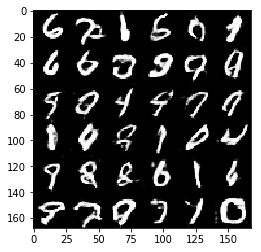

Epoch 2/2... Iteration 1510 Discriminator Loss: 1.2556... Generator Loss: 0.6055
Epoch 2/2... Iteration 1520 Discriminator Loss: 1.3544... Generator Loss: 0.5761
Epoch 2/2... Iteration 1530 Discriminator Loss: 1.0426... Generator Loss: 1.1693
Epoch 2/2... Iteration 1540 Discriminator Loss: 0.8317... Generator Loss: 1.5043
Epoch 2/2... Iteration 1550 Discriminator Loss: 0.9493... Generator Loss: 1.0469
Epoch 2/2... Iteration 1560 Discriminator Loss: 1.0820... Generator Loss: 0.7932
Epoch 2/2... Iteration 1570 Discriminator Loss: 0.8826... Generator Loss: 1.6430
Epoch 2/2... Iteration 1580 Discriminator Loss: 2.2386... Generator Loss: 3.4989
Epoch 2/2... Iteration 1590 Discriminator Loss: 1.1470... Generator Loss: 0.7578
Epoch 2/2... Iteration 1600 Discriminator Loss: 1.0615... Generator Loss: 0.8505


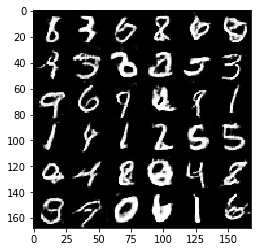

Epoch 2/2... Iteration 1610 Discriminator Loss: 0.7966... Generator Loss: 1.3725
Epoch 2/2... Iteration 1620 Discriminator Loss: 1.0731... Generator Loss: 0.8313
Epoch 2/2... Iteration 1630 Discriminator Loss: 0.9581... Generator Loss: 1.0675
Epoch 2/2... Iteration 1640 Discriminator Loss: 1.1526... Generator Loss: 0.7635
Epoch 2/2... Iteration 1650 Discriminator Loss: 0.8895... Generator Loss: 1.1561
Epoch 2/2... Iteration 1660 Discriminator Loss: 0.8466... Generator Loss: 1.4719
Epoch 2/2... Iteration 1670 Discriminator Loss: 0.7948... Generator Loss: 1.7352
Epoch 2/2... Iteration 1680 Discriminator Loss: 1.2577... Generator Loss: 0.6098
Epoch 2/2... Iteration 1690 Discriminator Loss: 0.9785... Generator Loss: 1.2945
Epoch 2/2... Iteration 1700 Discriminator Loss: 1.2881... Generator Loss: 2.1355


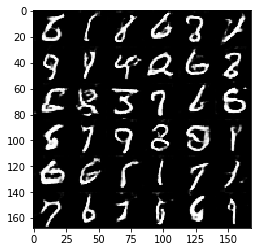

Epoch 2/2... Iteration 1710 Discriminator Loss: 1.0792... Generator Loss: 1.6586
Epoch 2/2... Iteration 1720 Discriminator Loss: 0.7663... Generator Loss: 1.5135
Epoch 2/2... Iteration 1730 Discriminator Loss: 0.9532... Generator Loss: 1.1171
Epoch 2/2... Iteration 1740 Discriminator Loss: 0.9367... Generator Loss: 0.9371
Epoch 2/2... Iteration 1750 Discriminator Loss: 1.0252... Generator Loss: 0.9199
Epoch 2/2... Iteration 1760 Discriminator Loss: 1.2831... Generator Loss: 0.6252
Epoch 2/2... Iteration 1770 Discriminator Loss: 1.1261... Generator Loss: 0.8602
Epoch 2/2... Iteration 1780 Discriminator Loss: 0.7537... Generator Loss: 1.7179
Epoch 2/2... Iteration 1790 Discriminator Loss: 1.7270... Generator Loss: 0.3767
Epoch 2/2... Iteration 1800 Discriminator Loss: 0.8933... Generator Loss: 1.1586


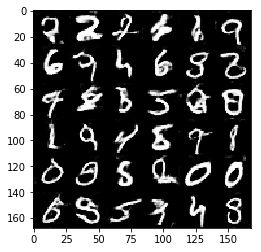

Epoch 2/2... Iteration 1810 Discriminator Loss: 0.8668... Generator Loss: 2.2310
Epoch 2/2... Iteration 1820 Discriminator Loss: 0.9879... Generator Loss: 0.9986
Epoch 2/2... Iteration 1830 Discriminator Loss: 1.0841... Generator Loss: 0.7759
Epoch 2/2... Iteration 1840 Discriminator Loss: 0.8628... Generator Loss: 1.1890
Epoch 2/2... Iteration 1850 Discriminator Loss: 1.0834... Generator Loss: 1.9640
Epoch 2/2... Iteration 1860 Discriminator Loss: 1.1674... Generator Loss: 1.8847
Epoch 2/2... Iteration 1870 Discriminator Loss: 0.8633... Generator Loss: 1.2299


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002

real_size = (28, 28, 1)
alpha = 0.2
beta1 = 0.5

print_every = 10
show_every = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

tf.reset_default_graph()

with tf.Graph().as_default():
    net = GAN(real_size, z_dim, learning_rate, alpha=alpha, beta1=beta1)
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, 
          print_every=print_every, show_every=show_every)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Iteration 10 Discriminator Loss: 0.7519... Generator Loss: 1.2078
Epoch 1/1... Iteration 20 Discriminator Loss: 0.6254... Generator Loss: 1.7403
Epoch 1/1... Iteration 30 Discriminator Loss: 2.6854... Generator Loss: 0.2026
Epoch 1/1... Iteration 40 Discriminator Loss: 0.9363... Generator Loss: 1.3049
Epoch 1/1... Iteration 50 Discriminator Loss: 1.4077... Generator Loss: 1.1321
Epoch 1/1... Iteration 60 Discriminator Loss: 1.4518... Generator Loss: 0.5673
Epoch 1/1... Iteration 70 Discriminator Loss: 0.9833... Generator Loss: 1.7551
Epoch 1/1... Iteration 80 Discriminator Loss: 1.4484... Generator Loss: 0.7208
Epoch 1/1... Iteration 90 Discriminator Loss: 1.3161... Generator Loss: 0.8038
Epoch 1/1... Iteration 100 Discriminator Loss: 1.3642... Generator Loss: 1.3703


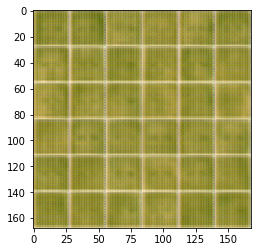

Epoch 1/1... Iteration 110 Discriminator Loss: 1.0886... Generator Loss: 1.1304
Epoch 1/1... Iteration 120 Discriminator Loss: 1.3502... Generator Loss: 0.7480
Epoch 1/1... Iteration 130 Discriminator Loss: 1.2286... Generator Loss: 0.8845
Epoch 1/1... Iteration 140 Discriminator Loss: 1.5344... Generator Loss: 1.3905
Epoch 1/1... Iteration 150 Discriminator Loss: 1.4967... Generator Loss: 0.6872
Epoch 1/1... Iteration 160 Discriminator Loss: 1.7302... Generator Loss: 0.4034
Epoch 1/1... Iteration 170 Discriminator Loss: 1.1064... Generator Loss: 1.1547
Epoch 1/1... Iteration 180 Discriminator Loss: 1.5532... Generator Loss: 0.4516
Epoch 1/1... Iteration 190 Discriminator Loss: 1.4254... Generator Loss: 0.8272
Epoch 1/1... Iteration 200 Discriminator Loss: 1.0540... Generator Loss: 1.0318


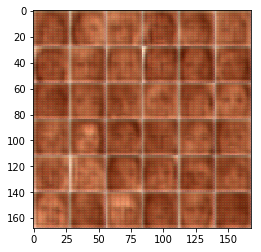

Epoch 1/1... Iteration 210 Discriminator Loss: 1.6812... Generator Loss: 0.8794
Epoch 1/1... Iteration 220 Discriminator Loss: 1.2983... Generator Loss: 1.6630
Epoch 1/1... Iteration 230 Discriminator Loss: 0.9719... Generator Loss: 1.2089
Epoch 1/1... Iteration 240 Discriminator Loss: 1.2266... Generator Loss: 1.2144
Epoch 1/1... Iteration 250 Discriminator Loss: 1.2828... Generator Loss: 1.1613
Epoch 1/1... Iteration 260 Discriminator Loss: 1.1854... Generator Loss: 1.2363
Epoch 1/1... Iteration 270 Discriminator Loss: 1.2895... Generator Loss: 1.0671
Epoch 1/1... Iteration 280 Discriminator Loss: 1.4076... Generator Loss: 0.8003
Epoch 1/1... Iteration 290 Discriminator Loss: 1.9132... Generator Loss: 0.3281
Epoch 1/1... Iteration 300 Discriminator Loss: 1.1376... Generator Loss: 0.9183


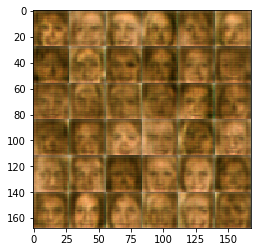

Epoch 1/1... Iteration 310 Discriminator Loss: 1.1101... Generator Loss: 1.1428
Epoch 1/1... Iteration 320 Discriminator Loss: 1.2738... Generator Loss: 1.1500
Epoch 1/1... Iteration 330 Discriminator Loss: 1.1009... Generator Loss: 1.0124
Epoch 1/1... Iteration 340 Discriminator Loss: 1.6049... Generator Loss: 0.4627
Epoch 1/1... Iteration 350 Discriminator Loss: 1.4643... Generator Loss: 0.8901
Epoch 1/1... Iteration 360 Discriminator Loss: 1.3233... Generator Loss: 0.8048
Epoch 1/1... Iteration 370 Discriminator Loss: 1.3824... Generator Loss: 1.3755
Epoch 1/1... Iteration 380 Discriminator Loss: 1.8112... Generator Loss: 0.3427
Epoch 1/1... Iteration 390 Discriminator Loss: 1.1954... Generator Loss: 0.8160
Epoch 1/1... Iteration 400 Discriminator Loss: 1.4205... Generator Loss: 0.7919


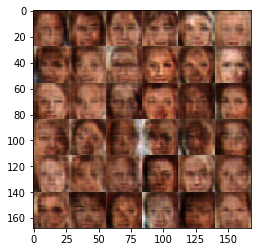

Epoch 1/1... Iteration 410 Discriminator Loss: 1.3192... Generator Loss: 0.8651
Epoch 1/1... Iteration 420 Discriminator Loss: 1.3832... Generator Loss: 1.1138
Epoch 1/1... Iteration 430 Discriminator Loss: 1.1173... Generator Loss: 1.0346
Epoch 1/1... Iteration 440 Discriminator Loss: 1.4587... Generator Loss: 0.7433
Epoch 1/1... Iteration 450 Discriminator Loss: 1.2918... Generator Loss: 1.1408
Epoch 1/1... Iteration 460 Discriminator Loss: 1.2246... Generator Loss: 0.9847
Epoch 1/1... Iteration 470 Discriminator Loss: 1.2769... Generator Loss: 0.9574
Epoch 1/1... Iteration 480 Discriminator Loss: 1.5280... Generator Loss: 0.7361
Epoch 1/1... Iteration 490 Discriminator Loss: 1.1784... Generator Loss: 0.9703
Epoch 1/1... Iteration 500 Discriminator Loss: 1.2860... Generator Loss: 1.0683


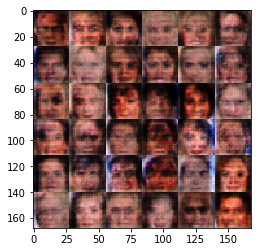

Epoch 1/1... Iteration 510 Discriminator Loss: 1.3476... Generator Loss: 0.6569
Epoch 1/1... Iteration 520 Discriminator Loss: 1.2459... Generator Loss: 0.7808
Epoch 1/1... Iteration 530 Discriminator Loss: 1.2507... Generator Loss: 0.9240
Epoch 1/1... Iteration 540 Discriminator Loss: 1.5966... Generator Loss: 0.4768
Epoch 1/1... Iteration 550 Discriminator Loss: 1.4393... Generator Loss: 0.8749
Epoch 1/1... Iteration 560 Discriminator Loss: 1.1211... Generator Loss: 0.8264
Epoch 1/1... Iteration 570 Discriminator Loss: 1.3613... Generator Loss: 0.8454
Epoch 1/1... Iteration 580 Discriminator Loss: 1.3015... Generator Loss: 0.9219
Epoch 1/1... Iteration 590 Discriminator Loss: 1.6137... Generator Loss: 0.4656
Epoch 1/1... Iteration 600 Discriminator Loss: 1.2454... Generator Loss: 0.9926


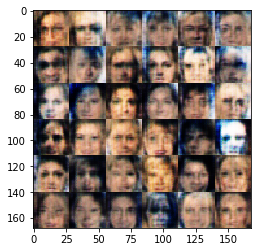

Epoch 1/1... Iteration 610 Discriminator Loss: 1.2886... Generator Loss: 0.8577
Epoch 1/1... Iteration 620 Discriminator Loss: 1.2329... Generator Loss: 0.7847
Epoch 1/1... Iteration 630 Discriminator Loss: 1.2589... Generator Loss: 0.6673
Epoch 1/1... Iteration 640 Discriminator Loss: 1.1454... Generator Loss: 1.0095
Epoch 1/1... Iteration 650 Discriminator Loss: 1.3983... Generator Loss: 0.6522
Epoch 1/1... Iteration 660 Discriminator Loss: 1.3059... Generator Loss: 0.7916
Epoch 1/1... Iteration 670 Discriminator Loss: 1.5266... Generator Loss: 1.1187
Epoch 1/1... Iteration 680 Discriminator Loss: 1.2878... Generator Loss: 0.9418
Epoch 1/1... Iteration 690 Discriminator Loss: 1.2928... Generator Loss: 1.1793
Epoch 1/1... Iteration 700 Discriminator Loss: 1.2141... Generator Loss: 0.8922


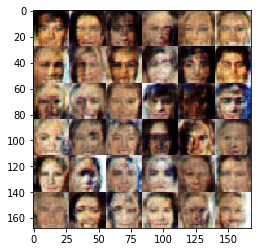

Epoch 1/1... Iteration 710 Discriminator Loss: 1.2882... Generator Loss: 1.0464
Epoch 1/1... Iteration 720 Discriminator Loss: 1.2381... Generator Loss: 0.9365
Epoch 1/1... Iteration 730 Discriminator Loss: 1.2301... Generator Loss: 0.9358
Epoch 1/1... Iteration 740 Discriminator Loss: 1.2541... Generator Loss: 0.7727
Epoch 1/1... Iteration 750 Discriminator Loss: 1.2495... Generator Loss: 0.9223
Epoch 1/1... Iteration 760 Discriminator Loss: 1.2023... Generator Loss: 0.8017
Epoch 1/1... Iteration 770 Discriminator Loss: 1.1514... Generator Loss: 1.1685
Epoch 1/1... Iteration 780 Discriminator Loss: 1.1801... Generator Loss: 0.9225
Epoch 1/1... Iteration 790 Discriminator Loss: 1.3167... Generator Loss: 0.9354
Epoch 1/1... Iteration 800 Discriminator Loss: 1.3027... Generator Loss: 0.8842


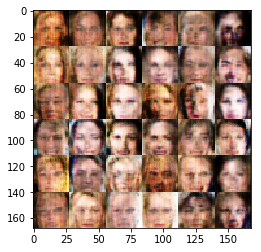

Epoch 1/1... Iteration 810 Discriminator Loss: 1.2396... Generator Loss: 0.7951
Epoch 1/1... Iteration 820 Discriminator Loss: 1.1913... Generator Loss: 0.7245
Epoch 1/1... Iteration 830 Discriminator Loss: 1.2910... Generator Loss: 0.7296
Epoch 1/1... Iteration 840 Discriminator Loss: 1.4153... Generator Loss: 0.6575
Epoch 1/1... Iteration 850 Discriminator Loss: 1.0998... Generator Loss: 1.0223
Epoch 1/1... Iteration 860 Discriminator Loss: 1.1803... Generator Loss: 0.8719
Epoch 1/1... Iteration 870 Discriminator Loss: 1.4134... Generator Loss: 0.7333
Epoch 1/1... Iteration 880 Discriminator Loss: 1.1693... Generator Loss: 0.9148
Epoch 1/1... Iteration 890 Discriminator Loss: 1.2449... Generator Loss: 0.9745
Epoch 1/1... Iteration 900 Discriminator Loss: 1.3986... Generator Loss: 0.5900


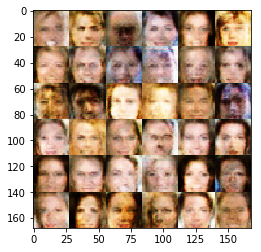

Epoch 1/1... Iteration 910 Discriminator Loss: 1.3442... Generator Loss: 1.2310
Epoch 1/1... Iteration 920 Discriminator Loss: 1.3474... Generator Loss: 1.1826
Epoch 1/1... Iteration 930 Discriminator Loss: 1.5631... Generator Loss: 0.7783
Epoch 1/1... Iteration 940 Discriminator Loss: 1.2285... Generator Loss: 1.1578
Epoch 1/1... Iteration 950 Discriminator Loss: 1.2724... Generator Loss: 1.2881
Epoch 1/1... Iteration 960 Discriminator Loss: 1.0457... Generator Loss: 1.0834
Epoch 1/1... Iteration 970 Discriminator Loss: 1.2406... Generator Loss: 0.9147
Epoch 1/1... Iteration 980 Discriminator Loss: 1.1298... Generator Loss: 1.1460
Epoch 1/1... Iteration 990 Discriminator Loss: 1.1542... Generator Loss: 1.2736
Epoch 1/1... Iteration 1000 Discriminator Loss: 1.3283... Generator Loss: 0.8244


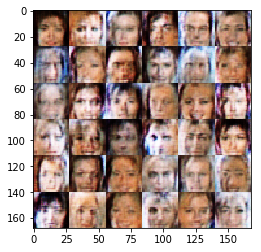

Epoch 1/1... Iteration 1010 Discriminator Loss: 1.2848... Generator Loss: 0.7877
Epoch 1/1... Iteration 1020 Discriminator Loss: 1.3673... Generator Loss: 0.7662
Epoch 1/1... Iteration 1030 Discriminator Loss: 1.2761... Generator Loss: 0.8950
Epoch 1/1... Iteration 1040 Discriminator Loss: 1.1849... Generator Loss: 1.0349
Epoch 1/1... Iteration 1050 Discriminator Loss: 1.3189... Generator Loss: 0.7278
Epoch 1/1... Iteration 1060 Discriminator Loss: 1.1069... Generator Loss: 1.2311
Epoch 1/1... Iteration 1070 Discriminator Loss: 1.2593... Generator Loss: 0.8644
Epoch 1/1... Iteration 1080 Discriminator Loss: 1.3108... Generator Loss: 0.6419
Epoch 1/1... Iteration 1090 Discriminator Loss: 1.2871... Generator Loss: 1.1185
Epoch 1/1... Iteration 1100 Discriminator Loss: 1.4437... Generator Loss: 0.6353


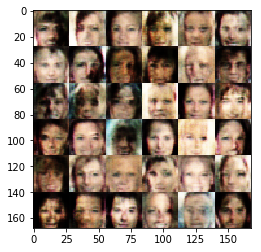

Epoch 1/1... Iteration 1110 Discriminator Loss: 1.2442... Generator Loss: 0.8402
Epoch 1/1... Iteration 1120 Discriminator Loss: 1.4360... Generator Loss: 0.9178
Epoch 1/1... Iteration 1130 Discriminator Loss: 1.2753... Generator Loss: 0.8894
Epoch 1/1... Iteration 1140 Discriminator Loss: 1.2598... Generator Loss: 1.0823
Epoch 1/1... Iteration 1150 Discriminator Loss: 1.2219... Generator Loss: 1.0475
Epoch 1/1... Iteration 1160 Discriminator Loss: 1.5019... Generator Loss: 0.7874
Epoch 1/1... Iteration 1170 Discriminator Loss: 1.1690... Generator Loss: 0.8280
Epoch 1/1... Iteration 1180 Discriminator Loss: 1.4024... Generator Loss: 0.8153
Epoch 1/1... Iteration 1190 Discriminator Loss: 1.5648... Generator Loss: 1.4329
Epoch 1/1... Iteration 1200 Discriminator Loss: 1.2054... Generator Loss: 0.8563


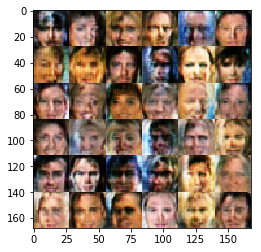

Epoch 1/1... Iteration 1210 Discriminator Loss: 1.3195... Generator Loss: 0.7962
Epoch 1/1... Iteration 1220 Discriminator Loss: 1.2343... Generator Loss: 0.8836
Epoch 1/1... Iteration 1230 Discriminator Loss: 1.3690... Generator Loss: 0.6835
Epoch 1/1... Iteration 1240 Discriminator Loss: 1.1828... Generator Loss: 0.8417
Epoch 1/1... Iteration 1250 Discriminator Loss: 1.3474... Generator Loss: 0.8241
Epoch 1/1... Iteration 1260 Discriminator Loss: 1.3211... Generator Loss: 0.9090
Epoch 1/1... Iteration 1270 Discriminator Loss: 1.2658... Generator Loss: 0.9180
Epoch 1/1... Iteration 1280 Discriminator Loss: 1.3346... Generator Loss: 1.1136
Epoch 1/1... Iteration 1290 Discriminator Loss: 1.1532... Generator Loss: 0.9574
Epoch 1/1... Iteration 1300 Discriminator Loss: 1.3406... Generator Loss: 0.7441


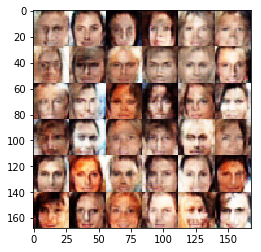

Epoch 1/1... Iteration 1310 Discriminator Loss: 1.1457... Generator Loss: 1.1177
Epoch 1/1... Iteration 1320 Discriminator Loss: 1.3088... Generator Loss: 0.8422
Epoch 1/1... Iteration 1330 Discriminator Loss: 1.2987... Generator Loss: 0.6691
Epoch 1/1... Iteration 1340 Discriminator Loss: 1.1848... Generator Loss: 1.0524
Epoch 1/1... Iteration 1350 Discriminator Loss: 1.4024... Generator Loss: 0.6677
Epoch 1/1... Iteration 1360 Discriminator Loss: 1.1462... Generator Loss: 1.0559
Epoch 1/1... Iteration 1370 Discriminator Loss: 1.2406... Generator Loss: 1.0614
Epoch 1/1... Iteration 1380 Discriminator Loss: 1.3680... Generator Loss: 0.9885
Epoch 1/1... Iteration 1390 Discriminator Loss: 1.1747... Generator Loss: 1.0734
Epoch 1/1... Iteration 1400 Discriminator Loss: 1.2022... Generator Loss: 0.8838


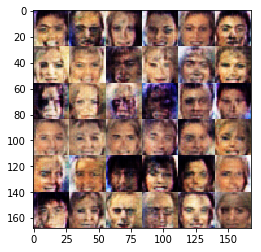

Epoch 1/1... Iteration 1410 Discriminator Loss: 1.4732... Generator Loss: 0.6966
Epoch 1/1... Iteration 1420 Discriminator Loss: 1.3000... Generator Loss: 1.0113
Epoch 1/1... Iteration 1430 Discriminator Loss: 1.3149... Generator Loss: 0.6028
Epoch 1/1... Iteration 1440 Discriminator Loss: 1.1879... Generator Loss: 0.8535
Epoch 1/1... Iteration 1450 Discriminator Loss: 1.1890... Generator Loss: 0.9020
Epoch 1/1... Iteration 1460 Discriminator Loss: 1.3418... Generator Loss: 0.7286
Epoch 1/1... Iteration 1470 Discriminator Loss: 1.2265... Generator Loss: 1.2141
Epoch 1/1... Iteration 1480 Discriminator Loss: 1.2973... Generator Loss: 0.8113
Epoch 1/1... Iteration 1490 Discriminator Loss: 1.2729... Generator Loss: 0.8290
Epoch 1/1... Iteration 1500 Discriminator Loss: 1.1022... Generator Loss: 0.9089


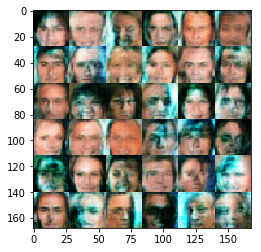

Epoch 1/1... Iteration 1510 Discriminator Loss: 1.2940... Generator Loss: 0.7116
Epoch 1/1... Iteration 1520 Discriminator Loss: 1.3840... Generator Loss: 0.6337
Epoch 1/1... Iteration 1530 Discriminator Loss: 1.2537... Generator Loss: 0.8929
Epoch 1/1... Iteration 1540 Discriminator Loss: 1.2839... Generator Loss: 0.7902
Epoch 1/1... Iteration 1550 Discriminator Loss: 1.2185... Generator Loss: 0.9214
Epoch 1/1... Iteration 1560 Discriminator Loss: 1.3611... Generator Loss: 0.9419
Epoch 1/1... Iteration 1570 Discriminator Loss: 1.3404... Generator Loss: 1.0720
Epoch 1/1... Iteration 1580 Discriminator Loss: 1.4437... Generator Loss: 0.7006
Epoch 1/1... Iteration 1590 Discriminator Loss: 1.1575... Generator Loss: 1.0078
Epoch 1/1... Iteration 1600 Discriminator Loss: 1.1695... Generator Loss: 0.9909


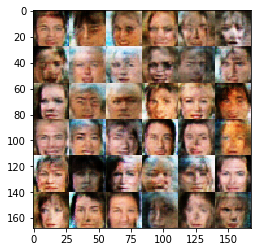

Epoch 1/1... Iteration 1610 Discriminator Loss: 1.2680... Generator Loss: 0.8533
Epoch 1/1... Iteration 1620 Discriminator Loss: 1.2533... Generator Loss: 1.0781
Epoch 1/1... Iteration 1630 Discriminator Loss: 1.2911... Generator Loss: 0.9172
Epoch 1/1... Iteration 1640 Discriminator Loss: 1.3433... Generator Loss: 0.8416
Epoch 1/1... Iteration 1650 Discriminator Loss: 1.3118... Generator Loss: 0.7136
Epoch 1/1... Iteration 1660 Discriminator Loss: 1.2767... Generator Loss: 0.9459
Epoch 1/1... Iteration 1670 Discriminator Loss: 1.2250... Generator Loss: 0.8441
Epoch 1/1... Iteration 1680 Discriminator Loss: 1.2685... Generator Loss: 0.9190
Epoch 1/1... Iteration 1690 Discriminator Loss: 1.3130... Generator Loss: 0.7319
Epoch 1/1... Iteration 1700 Discriminator Loss: 1.1926... Generator Loss: 0.9135


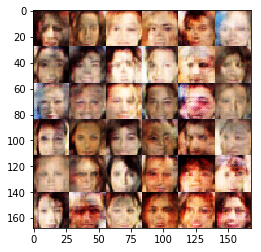

Epoch 1/1... Iteration 1710 Discriminator Loss: 1.1925... Generator Loss: 0.9732
Epoch 1/1... Iteration 1720 Discriminator Loss: 1.3211... Generator Loss: 0.8066
Epoch 1/1... Iteration 1730 Discriminator Loss: 1.1566... Generator Loss: 1.1485
Epoch 1/1... Iteration 1740 Discriminator Loss: 1.3310... Generator Loss: 0.7705
Epoch 1/1... Iteration 1750 Discriminator Loss: 1.3653... Generator Loss: 0.7734
Epoch 1/1... Iteration 1760 Discriminator Loss: 1.3095... Generator Loss: 1.0432
Epoch 1/1... Iteration 1770 Discriminator Loss: 1.2992... Generator Loss: 0.9549
Epoch 1/1... Iteration 1780 Discriminator Loss: 1.3280... Generator Loss: 0.8086
Epoch 1/1... Iteration 1790 Discriminator Loss: 1.0967... Generator Loss: 1.0836
Epoch 1/1... Iteration 1800 Discriminator Loss: 1.1669... Generator Loss: 1.0314


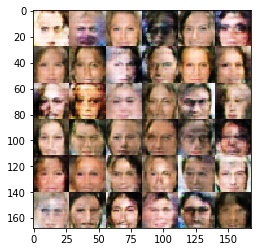

Epoch 1/1... Iteration 1810 Discriminator Loss: 1.2579... Generator Loss: 1.0041
Epoch 1/1... Iteration 1820 Discriminator Loss: 1.1717... Generator Loss: 1.0283
Epoch 1/1... Iteration 1830 Discriminator Loss: 1.2676... Generator Loss: 0.7735
Epoch 1/1... Iteration 1840 Discriminator Loss: 1.1990... Generator Loss: 0.8480
Epoch 1/1... Iteration 1850 Discriminator Loss: 1.1218... Generator Loss: 1.0130
Epoch 1/1... Iteration 1860 Discriminator Loss: 1.1524... Generator Loss: 0.9689
Epoch 1/1... Iteration 1870 Discriminator Loss: 1.2276... Generator Loss: 1.0409
Epoch 1/1... Iteration 1880 Discriminator Loss: 1.2065... Generator Loss: 0.9498
Epoch 1/1... Iteration 1890 Discriminator Loss: 1.3112... Generator Loss: 0.9699
Epoch 1/1... Iteration 1900 Discriminator Loss: 1.2419... Generator Loss: 1.1179


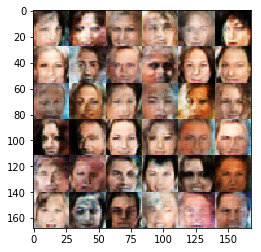

Epoch 1/1... Iteration 1910 Discriminator Loss: 1.3500... Generator Loss: 0.9182
Epoch 1/1... Iteration 1920 Discriminator Loss: 1.2513... Generator Loss: 0.8006
Epoch 1/1... Iteration 1930 Discriminator Loss: 1.1081... Generator Loss: 1.0003
Epoch 1/1... Iteration 1940 Discriminator Loss: 1.3416... Generator Loss: 0.8191
Epoch 1/1... Iteration 1950 Discriminator Loss: 1.1808... Generator Loss: 1.2562
Epoch 1/1... Iteration 1960 Discriminator Loss: 1.1465... Generator Loss: 1.1037
Epoch 1/1... Iteration 1970 Discriminator Loss: 1.2127... Generator Loss: 0.8410
Epoch 1/1... Iteration 1980 Discriminator Loss: 1.2096... Generator Loss: 0.8517
Epoch 1/1... Iteration 1990 Discriminator Loss: 1.2479... Generator Loss: 0.8687
Epoch 1/1... Iteration 2000 Discriminator Loss: 1.0633... Generator Loss: 1.4070


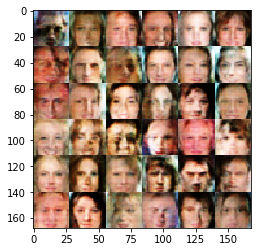

Epoch 1/1... Iteration 2010 Discriminator Loss: 1.3540... Generator Loss: 0.6897
Epoch 1/1... Iteration 2020 Discriminator Loss: 1.2949... Generator Loss: 0.8275
Epoch 1/1... Iteration 2030 Discriminator Loss: 1.2674... Generator Loss: 0.7562
Epoch 1/1... Iteration 2040 Discriminator Loss: 1.1767... Generator Loss: 0.8808
Epoch 1/1... Iteration 2050 Discriminator Loss: 1.1827... Generator Loss: 0.9281
Epoch 1/1... Iteration 2060 Discriminator Loss: 1.2576... Generator Loss: 0.8446
Epoch 1/1... Iteration 2070 Discriminator Loss: 1.1065... Generator Loss: 1.0401
Epoch 1/1... Iteration 2080 Discriminator Loss: 1.1998... Generator Loss: 0.8547
Epoch 1/1... Iteration 2090 Discriminator Loss: 1.3036... Generator Loss: 0.9438
Epoch 1/1... Iteration 2100 Discriminator Loss: 1.2108... Generator Loss: 0.8492


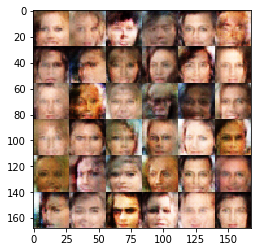

Epoch 1/1... Iteration 2110 Discriminator Loss: 1.1945... Generator Loss: 0.8921
Epoch 1/1... Iteration 2120 Discriminator Loss: 1.2259... Generator Loss: 0.9518
Epoch 1/1... Iteration 2130 Discriminator Loss: 1.3929... Generator Loss: 1.1877
Epoch 1/1... Iteration 2140 Discriminator Loss: 1.2076... Generator Loss: 0.7254
Epoch 1/1... Iteration 2150 Discriminator Loss: 1.1331... Generator Loss: 0.9323
Epoch 1/1... Iteration 2160 Discriminator Loss: 1.2762... Generator Loss: 0.8555
Epoch 1/1... Iteration 2170 Discriminator Loss: 1.1453... Generator Loss: 1.0060
Epoch 1/1... Iteration 2180 Discriminator Loss: 1.3701... Generator Loss: 0.9356
Epoch 1/1... Iteration 2190 Discriminator Loss: 1.1779... Generator Loss: 0.9229
Epoch 1/1... Iteration 2200 Discriminator Loss: 1.2474... Generator Loss: 0.8237


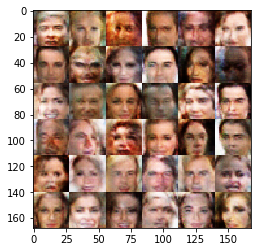

Epoch 1/1... Iteration 2210 Discriminator Loss: 1.1714... Generator Loss: 0.8996
Epoch 1/1... Iteration 2220 Discriminator Loss: 1.1080... Generator Loss: 0.9979
Epoch 1/1... Iteration 2230 Discriminator Loss: 1.2464... Generator Loss: 0.7326
Epoch 1/1... Iteration 2240 Discriminator Loss: 1.2238... Generator Loss: 0.7593
Epoch 1/1... Iteration 2250 Discriminator Loss: 1.2341... Generator Loss: 0.7182
Epoch 1/1... Iteration 2260 Discriminator Loss: 1.2826... Generator Loss: 0.6938
Epoch 1/1... Iteration 2270 Discriminator Loss: 1.1333... Generator Loss: 0.8194
Epoch 1/1... Iteration 2280 Discriminator Loss: 1.3654... Generator Loss: 0.5962
Epoch 1/1... Iteration 2290 Discriminator Loss: 1.1868... Generator Loss: 0.8911
Epoch 1/1... Iteration 2300 Discriminator Loss: 1.2092... Generator Loss: 1.1693


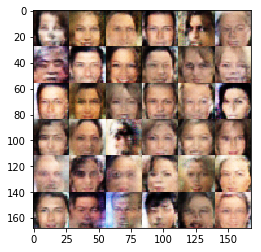

Epoch 1/1... Iteration 2310 Discriminator Loss: 1.2979... Generator Loss: 0.7283
Epoch 1/1... Iteration 2320 Discriminator Loss: 1.3326... Generator Loss: 0.6423
Epoch 1/1... Iteration 2330 Discriminator Loss: 1.3058... Generator Loss: 0.9907
Epoch 1/1... Iteration 2340 Discriminator Loss: 1.1229... Generator Loss: 1.0342
Epoch 1/1... Iteration 2350 Discriminator Loss: 1.1474... Generator Loss: 0.9644
Epoch 1/1... Iteration 2360 Discriminator Loss: 1.2171... Generator Loss: 0.8988
Epoch 1/1... Iteration 2370 Discriminator Loss: 1.1994... Generator Loss: 0.8557
Epoch 1/1... Iteration 2380 Discriminator Loss: 1.3324... Generator Loss: 0.7798
Epoch 1/1... Iteration 2390 Discriminator Loss: 1.2968... Generator Loss: 0.6925
Epoch 1/1... Iteration 2400 Discriminator Loss: 1.1037... Generator Loss: 0.8519


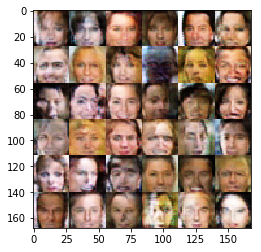

Epoch 1/1... Iteration 2410 Discriminator Loss: 1.3122... Generator Loss: 0.8834
Epoch 1/1... Iteration 2420 Discriminator Loss: 1.2946... Generator Loss: 0.8138
Epoch 1/1... Iteration 2430 Discriminator Loss: 1.4676... Generator Loss: 0.5099
Epoch 1/1... Iteration 2440 Discriminator Loss: 1.3917... Generator Loss: 0.8044
Epoch 1/1... Iteration 2450 Discriminator Loss: 1.2836... Generator Loss: 0.8626
Epoch 1/1... Iteration 2460 Discriminator Loss: 1.6430... Generator Loss: 0.5508
Epoch 1/1... Iteration 2470 Discriminator Loss: 1.3152... Generator Loss: 1.0195
Epoch 1/1... Iteration 2480 Discriminator Loss: 1.2194... Generator Loss: 0.9127
Epoch 1/1... Iteration 2490 Discriminator Loss: 1.2443... Generator Loss: 0.8172
Epoch 1/1... Iteration 2500 Discriminator Loss: 1.4261... Generator Loss: 1.1266


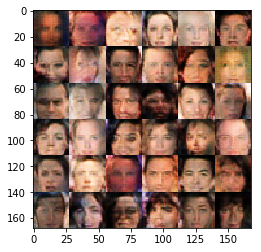

Epoch 1/1... Iteration 2510 Discriminator Loss: 1.1893... Generator Loss: 0.8721
Epoch 1/1... Iteration 2520 Discriminator Loss: 1.2864... Generator Loss: 0.6521
Epoch 1/1... Iteration 2530 Discriminator Loss: 1.2144... Generator Loss: 0.9240
Epoch 1/1... Iteration 2540 Discriminator Loss: 1.0581... Generator Loss: 0.9324
Epoch 1/1... Iteration 2550 Discriminator Loss: 1.2092... Generator Loss: 0.8546
Epoch 1/1... Iteration 2560 Discriminator Loss: 1.2884... Generator Loss: 0.9288
Epoch 1/1... Iteration 2570 Discriminator Loss: 1.1036... Generator Loss: 1.0308
Epoch 1/1... Iteration 2580 Discriminator Loss: 1.2003... Generator Loss: 0.8265
Epoch 1/1... Iteration 2590 Discriminator Loss: 1.2633... Generator Loss: 1.0018
Epoch 1/1... Iteration 2600 Discriminator Loss: 1.1394... Generator Loss: 0.8560


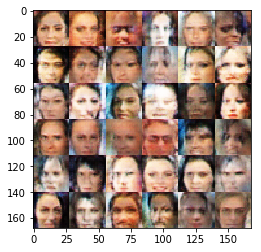

Epoch 1/1... Iteration 2610 Discriminator Loss: 1.2087... Generator Loss: 0.9850
Epoch 1/1... Iteration 2620 Discriminator Loss: 1.2295... Generator Loss: 0.9824
Epoch 1/1... Iteration 2630 Discriminator Loss: 1.2856... Generator Loss: 0.7398
Epoch 1/1... Iteration 2640 Discriminator Loss: 1.2165... Generator Loss: 0.8153
Epoch 1/1... Iteration 2650 Discriminator Loss: 1.2396... Generator Loss: 0.8958
Epoch 1/1... Iteration 2660 Discriminator Loss: 1.1292... Generator Loss: 0.9112
Epoch 1/1... Iteration 2670 Discriminator Loss: 1.4320... Generator Loss: 0.6737
Epoch 1/1... Iteration 2680 Discriminator Loss: 1.2268... Generator Loss: 1.0973
Epoch 1/1... Iteration 2690 Discriminator Loss: 1.2064... Generator Loss: 1.0444
Epoch 1/1... Iteration 2700 Discriminator Loss: 1.3146... Generator Loss: 0.8507


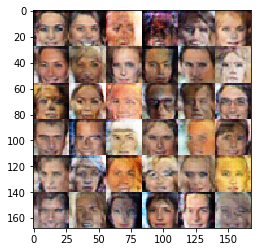

Epoch 1/1... Iteration 2710 Discriminator Loss: 1.3129... Generator Loss: 0.8210
Epoch 1/1... Iteration 2720 Discriminator Loss: 1.1681... Generator Loss: 0.9264
Epoch 1/1... Iteration 2730 Discriminator Loss: 1.2511... Generator Loss: 0.7244
Epoch 1/1... Iteration 2740 Discriminator Loss: 1.1854... Generator Loss: 0.8774
Epoch 1/1... Iteration 2750 Discriminator Loss: 1.1984... Generator Loss: 0.8607
Epoch 1/1... Iteration 2760 Discriminator Loss: 1.1628... Generator Loss: 0.9366
Epoch 1/1... Iteration 2770 Discriminator Loss: 1.3925... Generator Loss: 0.5618
Epoch 1/1... Iteration 2780 Discriminator Loss: 1.2541... Generator Loss: 1.0733
Epoch 1/1... Iteration 2790 Discriminator Loss: 1.1643... Generator Loss: 0.9079
Epoch 1/1... Iteration 2800 Discriminator Loss: 1.1280... Generator Loss: 1.1167


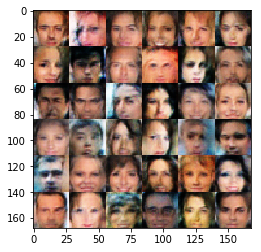

Epoch 1/1... Iteration 2810 Discriminator Loss: 1.3710... Generator Loss: 0.6486
Epoch 1/1... Iteration 2820 Discriminator Loss: 1.1846... Generator Loss: 1.1650
Epoch 1/1... Iteration 2830 Discriminator Loss: 1.1512... Generator Loss: 1.0790
Epoch 1/1... Iteration 2840 Discriminator Loss: 1.2381... Generator Loss: 0.8882
Epoch 1/1... Iteration 2850 Discriminator Loss: 1.2831... Generator Loss: 0.8689
Epoch 1/1... Iteration 2860 Discriminator Loss: 1.2291... Generator Loss: 0.8228
Epoch 1/1... Iteration 2870 Discriminator Loss: 1.2318... Generator Loss: 0.9550
Epoch 1/1... Iteration 2880 Discriminator Loss: 1.2097... Generator Loss: 0.7944
Epoch 1/1... Iteration 2890 Discriminator Loss: 1.3980... Generator Loss: 0.9211
Epoch 1/1... Iteration 2900 Discriminator Loss: 1.2358... Generator Loss: 0.7907


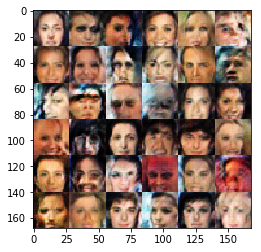

Epoch 1/1... Iteration 2910 Discriminator Loss: 1.3591... Generator Loss: 0.6225
Epoch 1/1... Iteration 2920 Discriminator Loss: 1.1905... Generator Loss: 1.0119
Epoch 1/1... Iteration 2930 Discriminator Loss: 1.1623... Generator Loss: 0.8742
Epoch 1/1... Iteration 2940 Discriminator Loss: 1.2513... Generator Loss: 0.7939
Epoch 1/1... Iteration 2950 Discriminator Loss: 1.3015... Generator Loss: 0.7739
Epoch 1/1... Iteration 2960 Discriminator Loss: 1.3043... Generator Loss: 0.7066
Epoch 1/1... Iteration 2970 Discriminator Loss: 1.1454... Generator Loss: 0.8617
Epoch 1/1... Iteration 2980 Discriminator Loss: 1.1671... Generator Loss: 1.0209
Epoch 1/1... Iteration 2990 Discriminator Loss: 1.2193... Generator Loss: 0.9112
Epoch 1/1... Iteration 3000 Discriminator Loss: 1.2406... Generator Loss: 0.9770


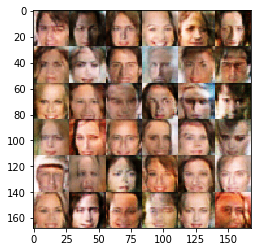

Epoch 1/1... Iteration 3010 Discriminator Loss: 1.2796... Generator Loss: 0.7644
Epoch 1/1... Iteration 3020 Discriminator Loss: 1.1711... Generator Loss: 0.9722
Epoch 1/1... Iteration 3030 Discriminator Loss: 1.2178... Generator Loss: 1.0651
Epoch 1/1... Iteration 3040 Discriminator Loss: 1.1476... Generator Loss: 1.0849
Epoch 1/1... Iteration 3050 Discriminator Loss: 1.2983... Generator Loss: 0.7342
Epoch 1/1... Iteration 3060 Discriminator Loss: 1.2215... Generator Loss: 0.8995
Epoch 1/1... Iteration 3070 Discriminator Loss: 1.4690... Generator Loss: 0.5839
Epoch 1/1... Iteration 3080 Discriminator Loss: 1.2104... Generator Loss: 0.8106
Epoch 1/1... Iteration 3090 Discriminator Loss: 1.2180... Generator Loss: 0.9547
Epoch 1/1... Iteration 3100 Discriminator Loss: 1.2314... Generator Loss: 0.7329


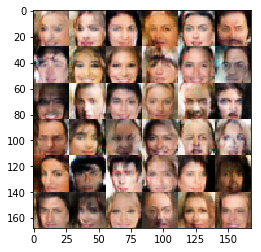

Epoch 1/1... Iteration 3110 Discriminator Loss: 1.3071... Generator Loss: 0.7441
Epoch 1/1... Iteration 3120 Discriminator Loss: 1.1568... Generator Loss: 0.8925
Epoch 1/1... Iteration 3130 Discriminator Loss: 1.1939... Generator Loss: 0.9612
Epoch 1/1... Iteration 3140 Discriminator Loss: 1.1568... Generator Loss: 0.9359
Epoch 1/1... Iteration 3150 Discriminator Loss: 1.3594... Generator Loss: 0.8255
Epoch 1/1... Iteration 3160 Discriminator Loss: 1.2098... Generator Loss: 0.9589


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002

real_size = (28, 28, 3)
epochs = 25
alpha = 0.2
beta1 = 0.5

print_every = 10
show_every = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    net = GAN(real_size, z_dim, learning_rate, alpha=alpha, beta1=beta1)
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode,
          print_every=print_every, show_every=show_every)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.